# Tutorial 6 Make boundary conditions on Intersections

In this tutorial, you will learn how to apply Dirichlet boundary conditions on intersections between fractures.

We assume that you are familiar to 
- the generation of DFN, if not, you can refer to [Tuto2](https://gitlab.com/fractorylab/dfnlab/-/blob/master/Tutorials/Tuto2_Generation_DFN_stochastic.ipynb)
- the mesh generation [Tuto3](https://gitlab.com/fractorylab/dfnlab/-/blob/master/Tutorials/Tuto2_Generation_DFN_stochastic.ipynb)
- solving a Darcy equations problem and particles tracking

## Learning example

Here we create a simple system with one central fracture, where flow is studied, and two connecting fractures to create intersections where boundary conditions are applied.

### Creation of the system

In [1]:
# python libraries import
import sys, os, math, numpy as np
#DFNlab import
import dfnlab.DFNBasis as dfnB
import dfnlab.GeometryLib as geom
import dfnlab.DFNGenerator as dfnG
import dfnlab.DFNGraph as dfnGr
import dfnlab.DFNHydro as dfn_hydro
import dfnlab.DFNAnalysis as dfnA
import dfnlab.RandomGenerator as rng
import dfnlab.DFNMesh as dfn_mesh
import dfnlab.DFNFlow as dfn_solver
import dfnlab.DFNIO as dfnIO
import dfnlab.DFNBoundaryCondition as dfnBC
import dfnlab.DFNParticlesTracking as dfnPTrack
import pyvista as pv

In [2]:
display = True

In [3]:
system_size = [5,10,10]
system_center = [0,0,0]

print('initialization')
system = dfnB.System()
system.buildParallelepiped(system_center, system_size[0], system_size[1], system_size[2])

print('generation')
dfn = dfnB.DFN(system)

# The first crossing fracture
vect_polygon1 = [np.array([-10,-0.25*system_size[1],-0.445*system_size[2]]),np.array([0.01,-0.25*system_size[1],-0.445*system_size[2]]),np.array([0.01,0.25*system_size[1],-0.445*system_size[2]]),np.array([-10,0.25*system_size[1],-0.445*system_size[2]])]
fracture1 = dfnB.Fracture(geom.Polygon(vect_polygon1))

# The joint fracture
vect_polygon2 = [np.array([0,system_size[1], system_size[2]]),np.array([0,-system_size[1], system_size[2]]),np.array([0,-system_size[1],-system_size[2]]),np.array([0,system_size[1],-system_size[2]])]
fracture2 = dfnB.Fracture(geom.Polygon(vect_polygon2))

# The second crossing fracture
vect_polygon3 =[np.array([10,0.25*system_size[1],0.445*system_size[2]]),np.array([-0.01,0.25*system_size[1],0.445*system_size[2]]),np.array([-0.01,-0.25*system_size[1],0.445*system_size[2]]),np.array([10,-0.25*system_size[1],0.445*system_size[2]])]
fracture3 = dfnB.Fracture(geom.Polygon(vect_polygon3))

initialization
generation


In [4]:
dfn.addFracture(fracture1)
dfn.addFracture(fracture2)
dfn.addFracture(fracture3)

dfn.computeIntersections()

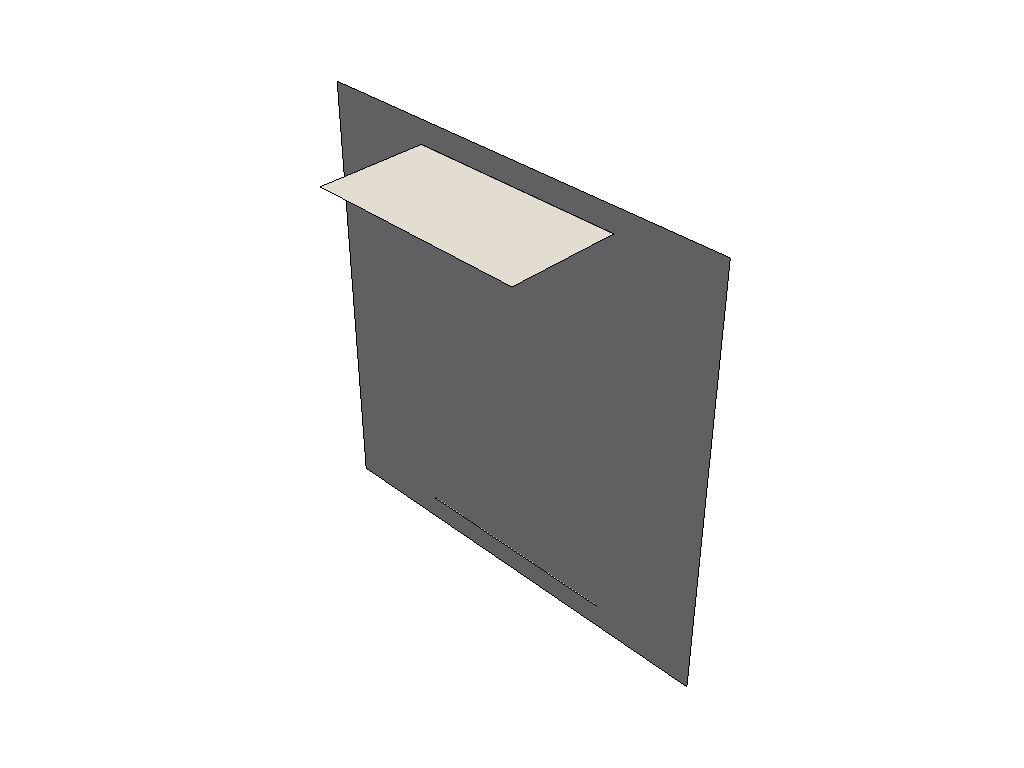

In [5]:
if display:
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder)
    dfnIO.write_DFN_file(dfn,pathFolder+"/dfn.vtp")
    visu = pv.read(pathFolder+"/dfn.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu, color='white', show_edges=True, edge_color='black', lighting=True, show_scalar_bar=True)
    p.show(auto_close=False, use_panel=False)

### Creation of the boundary conditions 

We impose fixed heads, on the first intersection it is equal to $dP/2$ and toy $-dP/2$ on the second one, with $dP$ is the head gradient.

In [6]:
dP = 10 # charge differential

boundaries = dfnBC.DomainBoundaryCondition()
  # The intersection must be in a list!, the first argument is the dfn, then the hydraulic heads value that will bve applied, then the list of the given intersections.
boundaries.setIntersectionInBC(dfn, dP/2, [dfn.getIntersectionFracture(0)])
boundaries.setIntersectionInBC(dfn, -dP/2, [dfn.getIntersectionFracture(1)])


# For safety, we aplly null fluw boundary conditions on the domain
boundaries.setFixedFlux(dfn,0,0)
boundaries.setFixedFlux(dfn,1,0)
boundaries.setFixedFlux(dfn,2,0)
boundaries.setFixedFlux(dfn,3,0)
boundaries.setFixedFlux(dfn,4,0)
boundaries.setFixedFlux(dfn,5,0)

#### Meshing and system resolution

In [7]:
hydro = dfn_hydro.HydraulicProperties(dfn)
hydro.setConstant(1)


mesh = dfn_mesh.DFNMesh(dfn)
mesh.setHydraulicProperties(hydro)
mesh.setCaracteristicLength(0.5)
mesh.setResolutionIntersection(1)
mesh.setResolutionGeometry(1)
mesh.setGradation(1.25)
print('generate mesh')
mesh.generateMesh()  

flow = dfn_solver.solveDarcyProblem(mesh,boundaries)

generate mesh
2
MMG_creationOfIntersections
Increase intersection size
MMG_computeIntersectionsOnIntersections
parallel research 
Generation of edges 
0 intersections empty
Jarvis 
check the edges are Delaunay - preparation of angles 
check the edges are Delaunay - criteria 1 and 2 
0 intersections empty
3 Fractures meshed  OK 
0 intersections are deleted not well defined after mesh 
Building of the linear system 
Time: to build the system: 0.0057027 seconds. 
Taking account of the boundary conditions
Linear System solving
Time: to reconstruct the velocities: 0.0020106 seconds. 


### Visualization

We display the resulting hydraulic heads.

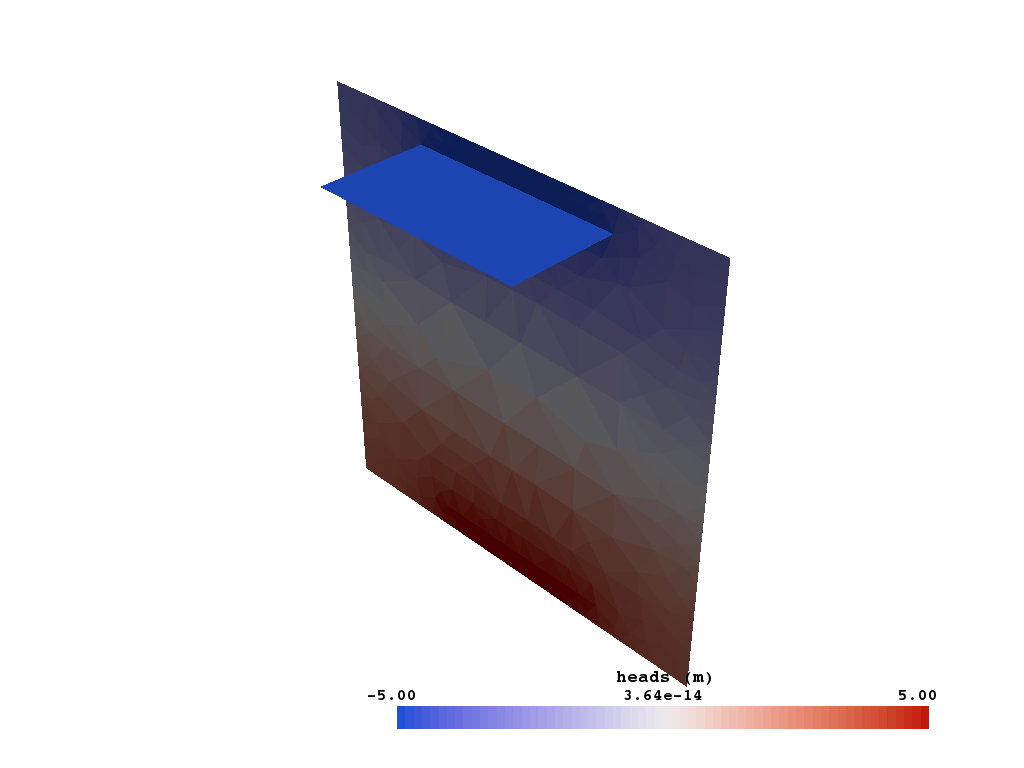

In [8]:
if display:
    
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder) 

    Aw = dfnIO.DFNIO_Object(mesh)
    Aw.appendDataOnMesh(flow.head(),"heads (m)")
    Aw.appendDataOnMesh(flow.velocity(),"velocities (m/s)")
    Aw.appendDataOnMesh(flow.flow(),"total discharge (m^3/s)")
    Aw.writeVTKOnMesh(pathFolder+"/PermeameterTest.vtp",True)


    visu = pv.read(pathFolder+"/PermeameterTest.vtp")
    p = pv.Plotter(notebook=True)
    argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
    p.set_background('white')
    p.add_mesh(visu,show_edges=False,scalars='heads (m)', cmap='coolwarm', lighting=True, show_scalar_bar=True, scalar_bar_args=argss)
    p.show(auto_close=False, use_panel=False)

### Generation of particles for particles tracking on intersections

The method is similar to one presented in the particles tracking tutorial. We first define the list of intersections where particles are injected (it is not compulsory that boundary conditions are applied at these intersections). 

In [9]:
setOfIntersections = [ dfn.getIntersectionFracture(0) ]
setOfFractures = []

The use a particle generator named GeneratorOnIntersection.

In [10]:
ParticuleSet =  dfnPTrack.ParticleSet(flow)

Generator = dfnPTrack.GeneratorOnIntersection(mesh,ParticuleSet,setOfIntersections,setOfFractures)

#### Running the example

In [11]:
Generator.generate(200);
ParticuleSet.saveAllTrajectory()
ParticuleSet.run()

We finally display the particle paths.

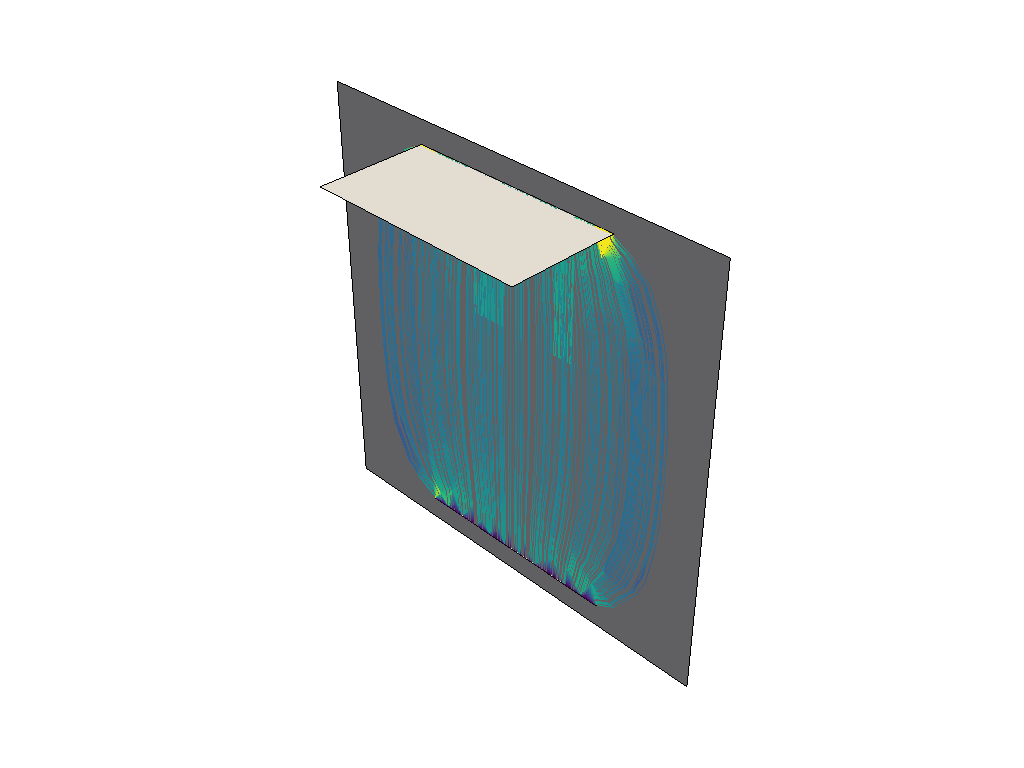

In [12]:
if display:
    
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder) 

    dfnIO.write_particle_file(ParticuleSet,pathFolder+"/PathParticule.vtp")
    dfnIO.write_DFN_file(dfn,pathFolder+"/dfn.vtp")

    visu = pv.read(pathFolder+"/PathParticule.vtp")
    visu2 = pv.read(pathFolder+"/dfn.vtp")
    p = pv.Plotter(notebook=True)
    argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
    p.set_background('white')
    p.add_mesh(visu, show_scalar_bar=False)
    p.add_mesh(visu2, color='white', show_edges=True, edge_color='black', lighting=True, show_scalar_bar=False)
    p.show(auto_close=False, use_panel=False)